In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import os
import math
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Preparation of the LoS tables
## Saves price and accessibility attribute to PT LoS table
## Needs PT LoS table and links

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
los = stepmodel.read_json(model_path + 'de_pt_los')
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [6]:
if 'route_type_disagg' in los.pt_los.columns:
    los.pt_los['route_type'] = los.pt_los['route_type_disagg']
    if los.pt_los['route_type'].isna().max():
        # Add main route_type based on a hierarchy
        hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
        def main_type(types):
            t = hierarchy[-1]
            try:
                t = hierarchy[min([hierarchy.index(t) for t in types])]
            except ValueError: # empty types set
                pass
            return t
        los.pt_los['route_type'] = los.pt_los['route_types'].apply(main_type)

In [7]:
# Make sure time is converted to seconds
if los.pt_los['time'].mean() < 10:
    los.pt_los['time'] = los.pt_los['time'] * 3600
los.pt_los['time'].mean()

20341.65674813416

In [8]:
sm.links.sample(2)

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway
index,,,,,,,,,,
bus_997799,bus,bus,"LINESTRING (8.63939 48.87038, 8.62902 48.86976)",b_DE12B_24,b_DE12B_39,1,bus_16455,480,bus_16455_0,8640
bus_x_97330,bus,bus,"LINESTRING (7.55515 50.15500, 7.55395 50.21118)",b_DEB1D_142,b_DEB1D_153,1,bus_x_6681,660,bus_x_6681_17,43200


In [9]:
# Add P&R LoS table, if available
if os.path.exists(model_path + 'de_pr_los/'):
    pr = stepmodel.read_json(model_path + 'de_pt_los')
    sm.pt_los = pd.concat([los.pt_los, pr.pr_los])
else:
    sm.pt_los = los.pt_los

## Prices

In [10]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)

In [11]:
sm.links['price'] = 0

In [12]:
type_dict = sm.links['route_type'].to_dict()

### Rail short-distance
Short-distance rail services have the price structure stated in the DB document. However, most people who use it have some kind of abonement and don't buy single trip tickets. cal10 shows that for trips under 50km distance there is a 50% share of permanent abonements. Moreover, it doesn't make sense to choose short-distance rail services on long distances. Still, if so, people choose the "Quer-durchs-Land-Ticket" for 42€.

In [13]:
mask = sm.links['route_type']=='rail_short'

In [14]:
# Load list of distance-related cost
c = pd.read_csv(input_path + 'level_of_service/DB_2020_preisliste_fahrplanjahr_2020.csv')
c.head(3)

,km,single_trip_second_class,single_trip_first_class,return_trip_second_class,return_trip_first_class
0,37.0,10.1,16.2,20.2,32.4
1,38.0,10.3,16.5,20.6,33.0
2,39.0,10.4,16.6,20.8,33.2


y=0.233*x+1.468


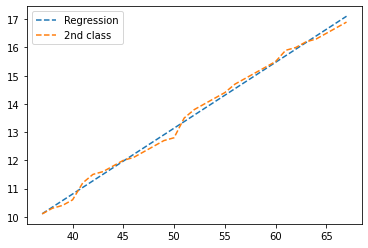

In [15]:
# Use second class single trip prices
# Choose a fit for a distance range up to 60 km (longer links are rare)
if manual:
    z = np.polyfit(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], deg=1)
    p = np.poly1d(z)
    plt.plot(c.loc[0:30, 'km'], p(c.loc[0:30, 'km']), linestyle='--', marker=' ', label='Regression')
    plt.plot(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], linestyle='--', marker=' ', label='2nd class')
    plt.legend()
    print('y={}*x+{}'.format(np.round(z[0], 3), np.round(z[1], 3)))

In [16]:
# Regression results
rail_short_slope = params['pt_price']['rail_short_slope']
rail_short_intercept = params['pt_price']['rail_short_intercept']

In [34]:
# Apply the slope to links
sm.links.loc[mask, 'price'] = sm.links.loc[mask, 'length'].apply(lambda d: d*rail_short_slope/1000)

In [35]:
# Sum link cost
price_dict = sm.links['price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='rail_short' else 0
                       for link in l]))

In [36]:
# Add the intercept
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] += rail_short_intercept

In [37]:
# Add a price floor for short-distance rail (and cap for consistency)
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'],
    params['pt_price']['min_rail_short'],
    params['pt_price']['max_rail_short'])

In [38]:
# Add abonements share for short-distance rail
#mask = (sm.pt_los['route_type']=='rail_short') & (sm.pt_los['length']<50000)
#sm.pt_los.loc[mask, 'price'] = sm.pt_los.loc[mask, 'price'] * (1-params['pt_price']['rail_short_abo_share'])

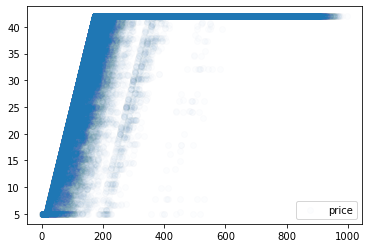

In [39]:
if manual:
    x = sm.pt_los.loc[sm.pt_los['route_type']=='rail_short']['length'] / 1000
    y = sm.pt_los.loc[sm.pt_los['route_type']=='rail_short']['price']
    plt.scatter(x, y, marker='o', alpha=.01, label='price')
    plt.legend()

In [40]:
len(sm.pt_los.loc[(sm.pt_los['route_type']=='rail_short') & (sm.pt_los['price']<5)])

0

### Rail long distance

Long-distance services have a complicated price structure that is not published by DB. Thus, we need to make assumptions based on a regression analysis of observation data (see prep32):

* Rail transport is purely path-distance and -duration-dependent
* Price dependency is linear
* There is a price cap of 139 EUR
* Assume 50/50 distribution of Sparpreis and Flexpreis

In [41]:
rl_dist_slope = params['pt_price']['rail_long_dist_slope']
rl_time_slope = params['pt_price']['rail_long_time_slope']
rl_intercept = params['pt_price']['rail_long_intercept']

In [42]:
# Apply the slope to links
mask = sm.links['route_type']=='rail_long'
sm.links.loc[mask, 'price'] = [d/1000*rl_dist_slope + t/3600*rl_time_slope
    for d,t in zip(sm.links.loc[mask, 'length'], sm.links.loc[mask, 'time'])]

In [43]:
# Sum link cost
price_dict = sm.links['price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='rail_long' else 0
                       for link in l]))

In [44]:
# Add an intercept
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] += rl_intercept

In [45]:
# Add a price cap and floor for long-distance rail
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'],
    params['pt_price']['min_rail_long'],
    params['pt_price']['max_rail_long'])

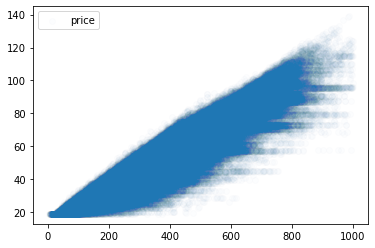

In [46]:
if manual:
    x = sm.pt_los.loc[sm.pt_los['route_type']=='rail_long']['length'] / 1000
    y = sm.pt_los.loc[sm.pt_los['route_type']=='rail_long']['price']
    plt.scatter(x, y, marker='o', alpha=.01, label='price')
    plt.legend()

### Coach

Assume a linear cost function based on distance. There are several sample studies available:
* Average cost in Germany (0.107 EUR/pkm): https://de.statista.com/statistik/daten/studie/380601/umfrage/kilometerpreise-fernbuslinien-in-deutschland/
* Average cost on selected OD pairs with cheapest prices: https://www.fernbusse.de/aktuelles/studie-fernbuspreise-steigen-leicht-bahntickets-guenstiger-1628/

The latter is more realistic

In [47]:
# Load list of OD pair cost
if manual:
    c = pd.read_excel(input_path + 'level_of_service/coach_prices_2017.xls')
    c.head(3)

In [48]:
sm.links.loc[sm.links['route_type']=='coach', 'price'] = \
    sm.links['length'] / 1000 * params['pt_price']['coach']

In [49]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='coach' else 0
                       for link in l]))

In [50]:
# Add a price cap and floor
sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'],
    params['pt_price']['min_coach'],
    params['pt_price']['max_coach'])

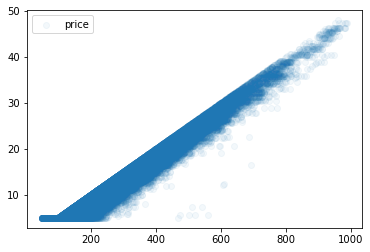

In [51]:
if manual:
    x = sm.pt_los.loc[sm.pt_los['route_type']=='coach']['length'] / 1000
    y = sm.pt_los.loc[sm.pt_los['route_type']=='coach']['price']
    plt.scatter(x, y, marker='o', alpha=.05, label='price')
    plt.legend()

### Air

Match air links with prices from an online search in Sept. 2020

<AxesSubplot:xlabel='time'>

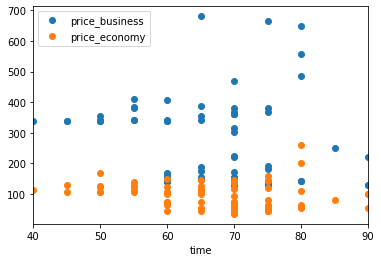

In [52]:
# Load connection list
air = pd.read_excel(input_path + 'public_transport/air_connections_germany.xls', engine='xlrd')
air = air.loc[air['direct']==True]
air['a'] = air['origin'].str[:3]
air['b'] = air['destination'].str[:3]
#print('Average economy price: {} EUR'.format(air['price_economy'].mean()))
#print('Average business price: {} EUR'.format(air['price_business'].mean()))
air[['price_business', 'price_economy', 'time']].set_index('time').plot(linestyle=' ', marker='o')

In [53]:
# Correct air time if neccessary
if sm.links.loc[sm.links['route_type']=='air', 'time'].mean() < 5*60:
    # Convert time to seconds
    sm.links.loc[sm.links['route_type']=='air', 'time'] *= 60

In [54]:
# Take the economy price because its share is higher
# than 90% within Germany
air['trip'] = air['a'] + '-' + air['b']
air_price_dict = air.set_index('trip')['price_economy'].to_dict()
mask = sm.links['route_type']=='air'
sm.links.loc[mask, 'price'] = sm.links.loc[mask, 'trip_id'].map(air_price_dict).fillna(
    params['pt_price']['air_economy'])
#print(len(sm.links.loc[(mask) & (sm.links['price'].isna())]))
sm.links.loc[mask].sample()

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway,length,price
index,,,,,,,,,,,,
air_27,air,air,"LINESTRING (7.14274 50.86590, 13.76720 51.13280)",CGN,DRS,1,air_27,3900,CGN-DRS,7200,464358,53.0


In [55]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
mask = sm.pt_los['route_type']=='air'
sm.pt_los.loc[mask, 'price'] = sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: sum([price_dict[link] if type_dict[link]
                   in ['air', 'rail_short', 'rail_long', 'coach'] else 0
                   for link in l]))
# Add intercepts of rail modes
sm.pt_los.loc[(mask) & (sm.pt_los['route_types'].apply(lambda l: 'rail_short' in l)),
              'price'] += rail_short_intercept
sm.pt_los.loc[(mask) & (sm.pt_los['route_types'].apply(lambda l: 'rail_long' in l)),
              'price'] += rl_intercept
sm.pt_los.loc[sm.pt_los['route_type']=='air', 'price'].mean()

145.9924450984629

In [56]:
len(sm.pt_los.loc[sm.pt_los['price'].isna()])

0

### Local transport

Local transport fares are added on top, as they are usually included into the rail ticket price or have a standalone price map dependent on ordinal distance classes.

In [57]:
# Add a fare for local transport services
# Get links with bus service at start or end of the trip
mode_dict = sm.links['route_type'].to_dict()
bus_at_o = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[0]]=='bus' if len(l)>0 else False)
bus_at_d = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[-1]]=='bus' if len(l)>0 else False)
only_bus = sm.pt_los['route_type']=='bus'
# Bus tickets are included in long-distance rail tickets
rail_long = sm.pt_los['route_types'].apply(lambda t: 'rail_long' in t)
# Define price structure by regional type
# Average value from ADAC for cities: https://www.adac.de/reise-freizeit/ratgeber/tests/oepnv-preise-vergleich/
region_dict = sm.zones['urbanisation'].to_dict()
region_prices = {1: params['pt_price']['bus_urban1'],
                 2: params['pt_price']['bus_urban2'],
                 3: params['pt_price']['bus_urban3']}

# Case 1: Multimodal
sm.pt_los.loc[(bus_at_o) & ~(only_bus) & ~(rail_long), 'price'] += sm.pt_los.loc[
    (bus_at_o) & ~(only_bus) & ~(rail_long), 'origin'].map(region_dict).map(region_prices)
sm.pt_los.loc[(bus_at_d) & ~(only_bus) & ~(rail_long), 'price'] += sm.pt_los.loc[
    (bus_at_d) & ~(only_bus) & ~(rail_long), 'destination'].map(region_dict).map(region_prices)

# Case 2: Only bus
sm.pt_los.loc[only_bus, 'price'] = [
    region_prices[max(region_dict[o], region_dict[d])]
    for o,d in zip(sm.pt_los.loc[only_bus, 'origin'], sm.pt_los.loc[only_bus, 'destination'])]

In [58]:
len(sm.pt_los.loc[sm.pt_los['price'].isna()])

0

In [59]:
sm.pt_los.groupby('route_type').agg(
    {'time': 'mean', 'price': 'mean', 'length': 'mean', 'ntransfers': 'mean'})

,time,price,length,ntransfers
route_type,,,,
air,24573.942511,147.221472,630601.039492,5.172077
bus,6157.289132,3.908973,53977.657478,3.589195
coach,17036.534247,17.130781,290121.248214,3.581869
rail_long,18523.098475,55.838611,406277.209165,2.774756
rail_short,22212.502496,40.117234,366464.251863,3.391966
walk,6239.264176,0.000000,29307.093159,0.000000


## Save

In [64]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(""('Fz1', 0)"", 'probability')","(""('Fz1', 1)"", 'probability')","(""('Fz2', 0)"", 'probability')","(""('Fz2', 1)"", 'probability')","(""('Fz3', 0)"", 'probability')","(""('Fz3', 1)"", 'probability')","(""('Fz4', 0)"", 'probability')","(""('Fz4', 1)"", 'probability')","(""('Fz6', 0)"", 'probability')","(""('Fz6', 1)"", 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
554797,1239,NaN,DE945,1324,16560,704140,"[bus_1236953, bus_1236955, bus_1236956, bus_12...",-4.142242,6,DEB3H,...,0.000023,0.00005,0.000001,0.000009,0.000012,0.000473,0.021985,0.016221,0.000008,0.009153


In [65]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:27<00:00,  1.28it/s]
